## Run this notebook in Google Colab by clicking here: [Google Colab](https://colab.research.google.com/github/AaronDJohnson/15yr_stochastic_analysis/blob/master/tutorials/parameter_est.ipynb)

### Run these cells if using Colab. Otherwise, skip them!

In [ ]:
# This cell will reset the kernel.
# Run this cell, wait until it's done, then run the next.
!pip install -q condacolab
import condacolab
condacolab.install_mambaforge()

In [ ]:
%%capture
!mamba install -y -c conda-forge enterprise_extensions la_forge h5pulsar ipympl
!git clone https://github.com/AaronDJohnson/15yr_stochastic_analysis
import sys
sys.path.insert(0,'/content/15yr_stochastic_analysis/tutorials')

# Using `enterprise` to perform parameter estimation on an isotropic stochastic gravitational wave background with the NANOGrav PTA

In this notebook you will learn:
* How to use `enterprise` to interact with NANOGrav data,

* How to search the full NANOGrav PTA for a common red noise process,

* How to perform parameter estimation on the NANOGrav 15-year data set.

# Load packages and modules

In [1]:
%load_ext autoreload
%autoreload 2

import glob, json, sys
import matplotlib.pyplot as plt
import numpy as np

from enterprise.signals import parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals import white_signals
from enterprise.signals import gp_signals

from extra_functions import EmpiricalDistribution2D

from enterprise_extensions.models import model_general
from enterprise_extensions import hypermodel
from enterprise_extensions import sampler as ee_sampler

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

from la_forge import core, diagnostics

from h5pulsar.pulsar import FilePulsar

import corner

IN_COLAB = 'google.colab' in sys.modules

Optional acor package is not installed. Acor is optionally used to calculate the effective chain length for output in the chain file.


In [2]:
if IN_COLAB:
    datadir = '/content/15yr_stochastic_analysis/tutorials/data'
else:
    datadir = './data'

## Load the full set of Pulsar objects

  * These files have been stored as `HDF5` files to make them much faster to load (and take up little space)
  
  * See the `explore_data.ipynb` tutorial to see what exists in these files and how to load `.par` and `.tim` files

In [3]:
psrs = []
for hdf5_file in glob.glob(datadir + '/hdf5/*.hdf5'):
    psrs.append(FilePulsar(hdf5_file))
print('Loaded {0} pulsars from hdf5 files'.format(len(psrs)))

Loaded 67 pulsars from hdf5 files


## Read in white noise dictionaries
  * We can read-in some previously computed noise properties from single-pulsar white noise analyses. These are things like `EFAC`, `EQUAD`, and (for `NANOGrav`) `ECORR`. 

  * In practice, we set these white-noise properties as fixed in the low-frequency noise / GW searches to reduce the computational cost of the analysis significantly.

  * The noise properties have been stored as `json` files, and are read into a big parameter dictionary.

In [4]:
## Get parameter noise dictionary
noise_ng15 = datadir + '/15yr_wn_dict.json'

wn_params = {}
with open(noise_ng15, 'r') as fp:
    wn_params.update(json.load(fp))

## Set up `enterprise` model for PTA GWB search

  * Here we use `enterprise` directly to describe how we build the GWB model
  
  * Afterward, we will use `enterprise_extensions` for common models

In [5]:
# find the maximum time span to set GW frequency sampling
tmin = [p.toas.min() for p in psrs]
tmax = [p.toas.max() for p in psrs]
Tspan = np.max(tmax) - np.min(tmin)

* We use the `Selection` object to define which noise parameters are assigned to which chunks of TOAs.

* This selection is based on unique combinations of backends and receivers, for example, GUPPI at Green Bank or PUPPI at Arecibo.
* For more information, see the [NANOGrav glossary](https://nanograv.org/glossary)

In [6]:
# define selection by observing backend
selection = selections.Selection(selections.by_backend)

### Priors

* White noise is fixed by using `Constant` parameters.

* In this case we do not specify a default value for all instances of that parameter but instead will set them (based on their initialized pulsar and backend specific name) later via the `set_default_params` method of our `PTA` object.

* For detection analyses we use a `Uniform` prior on the log of the GWB parameters and intrinsic red noise parameters.

In [7]:
# white noise parameters
efac = parameter.Constant() 
t2equad = parameter.Constant() 
ecorr = parameter.Constant()
# we'll set these later with the wn_params dictionary

# red noise parameters
log10_A = parameter.Uniform(-20, -11)
gamma = parameter.Uniform(0, 7)

# GW parameters (initialize with names here to use parameters in common across pulsars)
log10_A_gw = parameter.Uniform(-18, -14)('log10_A_gw')
gamma_gw = parameter.Uniform(0, 7)('gamma_gw')

### Signals

* With the priors specified, we now attach them to their associated signals.

* In this tutorial we work with red noise with a power law spectrum $\rho(f) = \frac{A^2}{12 \pi^2} \frac{1}{T}\left(\frac{f_i}{f_\mathrm{ref}}\right)^{-\gamma} \mathrm{yr}^2$

* Intrinsic red noise signals are expanded in a Fourier series with frequency bins at $f_i = i/T$ where $i = 1, 2, \ldots, 30$

* 30 is where we choose to stop and not a hard cutoff. This is enough to get the low-frequency content of the data.

* For the GWB, we search over 14 frequencies, because the 14th bin is where a "power law plus bend" model turns up, indicating that the spectrum becomes flatter with more white noise instead of red noise.

* First we will assume that this red noise is **uncorrelated** between pulsars, but later we will add in correlations which means that the pulse times of arrival in correlated models are synchronized in some way (either the model supports the pulses arriving together or apart, depending on the size of the angle between the pulsars on the sky).

* There are many possible correlations that we could check against our data. In particular, there are good reasons to check Hellings and Downs correlations which would indicate a GWB, and monopolar and dipolar correlations which may indicate issues with clocks or Solar System ephemerides.

* These exist in both `enterprise` and `enterprise_extensions` as **overlap reduction functions** (ORFs)

* If we want to search for a common uncorrelated red noise (CURN) signal among all pulsars, we use `FourierBasisGP`

* To add in Hellings and Downs (HD) correlations, a detection of which would be indicative of a GWB, we use `FourierBasisCommonGP` and input an `orf`

* Finally, the timing model includes a description of when every pulse from the pulsar will arrive

* We set `use_svd=True` to stabilize the timing model

* Timing model uncertainties are marginalized analytically. There are a couple of methods to do this, and the `MarginalizingTimingModel` will be faster when we don't vary the white noise parameters. So we use `MarginalizingTimingModel` instead of `TimingModel`. Note that both of these marginalize over the timing model, but one does this in two steps instead of one. See https://arxiv.org/abs/2306.16223 for more details.

In [8]:
# white noise
mn = white_signals.MeasurementNoise(efac=efac, log10_t2equad=t2equad, selection=selection)
ec = white_signals.EcorrKernelNoise(log10_ecorr=ecorr, selection=selection)

# red noise (powerlaw with 30 frequencies)
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn = gp_signals.FourierBasisGP(spectrum=pl, components=30, Tspan=Tspan)

# gwb (no spatial correlations)
cpl = utils.powerlaw(log10_A=log10_A_gw, gamma=gamma_gw)

# change from 30 to 14 frequencies to line up with the 15 year GWB search
curn = gp_signals.FourierBasisGP(spectrum=cpl, components=14, Tspan=Tspan, name='gw')

# for HD spatial correlations you can do...
# Note that this model is very slow compared to the CURN model above
# orf=utils.hd_orf()
# gwb = gp_signals.FourierBasisCommonGP(cpl, orf=utils.hd_orf(), components=14, Tspan=Tspan, name='gw')

# timing model
tm = gp_signals.MarginalizingTimingModel(use_svd=True)

### Create the full model

* In `enterprise`, we can add signals together and use them on a `Pulsar` object to make individual pulsar models.

* Calling `signal_base.PTA` on this list of pulsar models yields the final `PTA` object.

In [9]:
s = tm + mn + ec + rn + curn

In [10]:
models = []

for p in psrs:
    models.append(s(p))

pta = signal_base.PTA(models)

### Set the constant white noise parameters

In [11]:
pta.set_default_params(wn_params)

## Sample!

* With the PTA model in hand and with our constant parameters set to specific values, we are now ready to sample!

* NANOGrav's favorite sampler is `PTMCMCSampler`, a parallel tempering enabled Markov chain Monte Carlo sampler

* Stochastic sampling allows us to approximate the posterior distribution given by multiplying our likelihood and priors together. As is common in statistics, we use the log likelihood and prior instead.

* This stochastic sampler, uses an adaptive Metropolis-Hastings algorithm to sample the $\mathcal{O}(100)$ dimensional PTA parameter space

In [12]:
# set initial parameters drawn from prior
x0 = np.hstack([p.sample() for p in pta.params])
ndim = len(x0)

In [13]:
# set up the sampler:
# initial jump sample covariance matrix
# this helps decide which point is chosen next and the scale of the problem
cov = np.diag(np.ones(ndim) * 0.01**2)

# set the location to save the output chains
if IN_COLAB:
    outDir = '/content/15yr_stochastic_analysis/tutorials/chains/pe_chains'
else:
    outDir = './chains/pe_chains'

sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, 
                 outDir=outDir, resume=False)

### Empirical distributions

* Because of the high-dimensional parameter space, it can take a very long time for chains to find the "typical set" of the posterior. This just means the part of the parameter space that the sampler spends the most time in.

* This segment of finding the typical set is often called the "burn-in".

* To significantly reduce the burn-in, we can propose samples from 2D histograms of the red-noise parameter posteriors from noise runs performed on individual pulsars. These are often close enough to the posterior when also including a GWB that this speeds up the burn-in time significantly.

In [14]:
with open(datadir + '/15yr_emp_distr.json', 'r') as fp:
    emp_dists = json.load(fp)

In [15]:
emp_distr = []
for key in emp_dists.keys():
    emp_distr.append(EmpiricalDistribution2D(emp_dists[key]))

In [16]:
%%capture
# add empirical distribution to sampler:
jp = ee_sampler.JumpProposal(pta, empirical_distr=emp_distr)
sampler.addProposalToCycle(jp.draw_from_empirical_distr, 10)  # add empirical distribution draws with weight 10

### Sample!

* Doing this sampling takes many hours to get an adequate amount of samples to approximate the posterior. If we ask for 5 million samples, the output will be 500,000 samples. The reason for this is to reduce the amount of space required for the chain and to reduce the autocorrelation between chain samples (this will reduce it by a factor of 10). Independent samples quantify the uncertainty on the approximation to the posterior that we get at the end of sampling.

* While you are welcome to do this yourself, we have included a full set of samples from the posterior

* We can post process these precomputed chains and discuss the results immediately.

In [17]:
# sampler for N iterations (uncomment the last line if you want to sample this yourself)
# PTMCMCSampler thins the chain by default, so we get 1/10th of the samples we ask for
N = int(5e6)
x0 = np.hstack([p.sample() for p in pta.params])
# sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

### Post-process with `la_forge`

* `la_forge` uses custom `Core` objects to store MCMC chains from `PTMCMCSampler` into `HDF5` file formats.

* This compresses the chains into a small enough size that they can be easily transferred.

* Here we will look at the `Core` that results from the above model. This model involves a common uncorrelated red noise (CURN) process.

In [18]:
# To load your own chains, include the chain folder's path in core.Core()
# sampled_core = core.Core(outDir)

In [19]:
# set the location to load presampled chains from
if IN_COLAB:
    presampled = '/content/15yr_stochastic_analysis/tutorials/presampled_cores'
else:
    presampled = './presampled_cores'

In [20]:
crn_core = core.Core(corepath=presampled + '/curn_14f_pl_vg.core')

* Using the `diagnostics` module of `la_forge`, we can test that the chains stay in one place over the duration of the chain with the Gelman-Rubin $\hat{R}$ diagnostic using `grubin`.

* This is one method to ensure that convergence has been reached (although it is not guaranteed by this test!). It splits the chain into multiple pieces and compares the within and between chain segment variances to decide whether the chain is stationary.

* Additionally, we can check the number of effective samples in the chain with `plot_neff` or plot the marginalized posteriors with `plot_chains`.

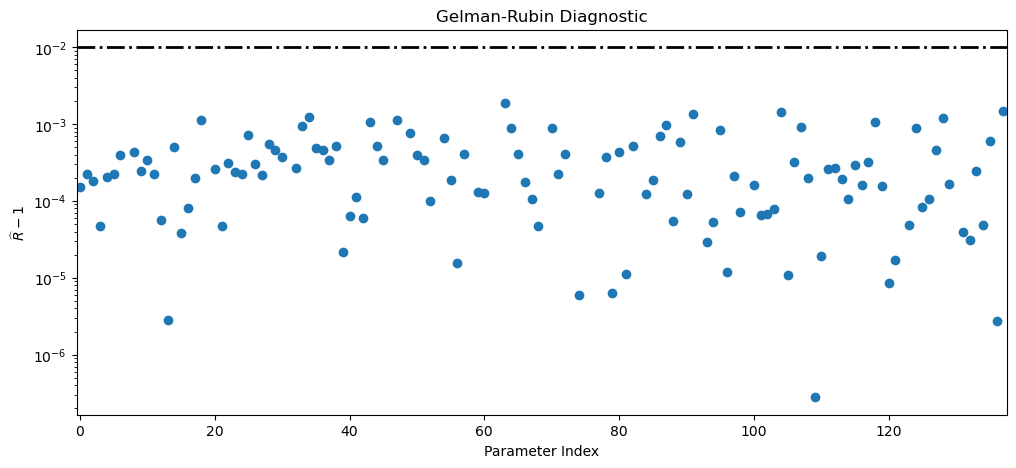

In [21]:
# A threshold of 1.01 suggests that the chain has reached a stationary state
diagnostics.plot_grubin(crn_core)

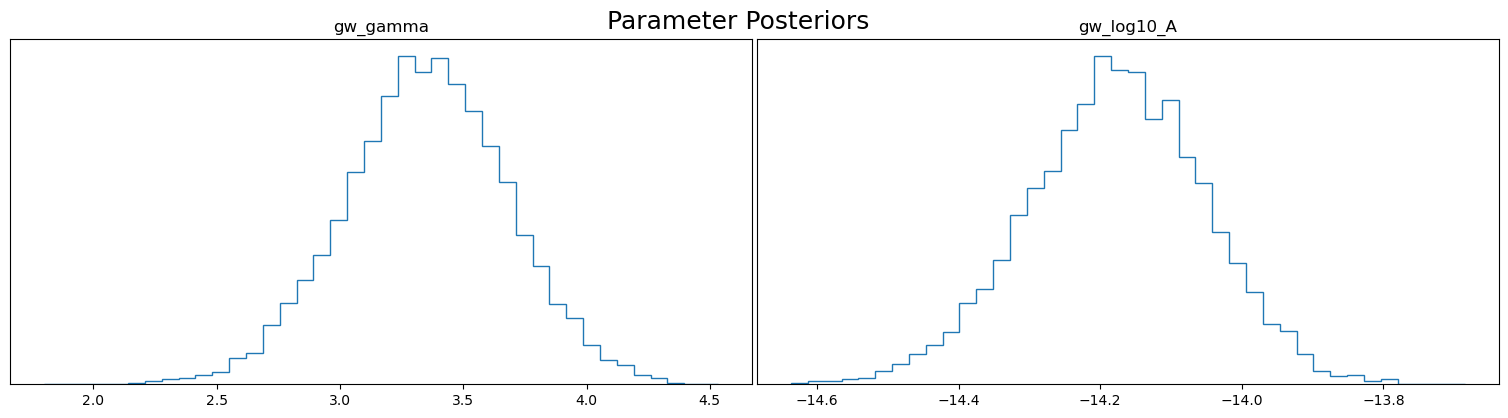

In [22]:
diagnostics.plot_chains(crn_core, pars=['gw_gamma', 'gw_log10_A'], ncols=2)

* To plot the joint posterior for these two parameters, we use `corner`

* Typically, the reference frequency ($f_\mathrm{ref}$ in the cell above) is set to $1/\mathrm{ yr}$, but in this case, we also plot $1/(10\mathrm{yr})$

* When the reference frequency is set to $\mathrm{yr}^{-1}$, the amplitude ($\log_{10}A$) and spectral index ($\gamma$) appear correlated, but this disappears when we set $f_{\mathrm{ref}}$ to a more sensitive frequency.

* PTAs are not sensitive to frequencies of $\mathrm{yr}^{-1}$ due to fitting of proper motion and pulsar position parameters in the timing model

* A vertical line at $\gamma = 13/3$ indicates the spectral index that is expected for an ensemble of supermassive black hole binaries emitting gravitational waves. Lower $\gamma$ could result from environmental effects nearby these binaries.

In [23]:
joint_1yr = np.array([crn_core.get_param('gw_gamma'), crn_core.get_param('gw_log10_A')]).T

def joint_correction(yrs):
    correction = 0.5 * (3 - crn_core.get_param('gw_gamma')) * np.log10(1/yrs)
    joint = correction + crn_core.get_param('gw_log10_A')
    return joint

# change 10 in the next line to the number of years you want to see how it affects the correlation!
joint_10yr = np.array([crn_core.get_param('gw_gamma'), joint_correction(10)]).T

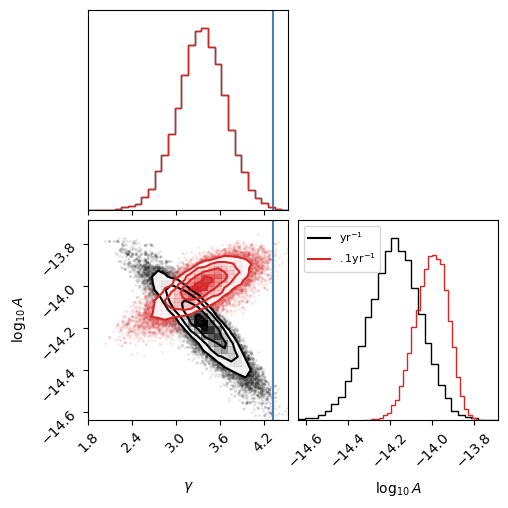

In [24]:
fig = corner.corner(joint_1yr, truths=[13/3, None], bins=30, color='black', labels=[r'$\gamma$', r'$\log_{10}A$'])
plt.plot([], [], color='black', label=r'$\mathrm{yr}^{-1}$')
plt.plot([], [], color='C3', label=r'$.1\mathrm{yr}^{-1}$')
corner.corner(joint_10yr, bins=30, color='C3', fig=fig)
plt.legend(loc='upper left', fontsize=8)

plt.show()

* The maximum posterior amplitude depends on the $f_\mathrm{ref}$ that we choose for our model.

* $\gamma = 4.33$ falls at the edge of the posterior. While we have a physical reason to suspect that $\gamma$ might fall on or near this value, our model is only marginally consistent with it.

* If we change the model for dispersion measure variations from a piecewise constant (DMX) to a Gaussian process (DMGP), we find that that model has more support for this value. That is, the values supported by our posterior is dependent on the noise models, and we should wait and see how this changes with further observations and data.

* **Finding a value that is not $13/3$ doesn't imply that anything is wrong with the model.** We can't know *a priori* what value this $\gamma$ takes in the real world or even if the power law model is the correct model to use in the first place. All we can say is "if we use a power law model on the  (with other underlying assumptions, such as stationary noise, etc.), then we find this posterior distribution of $\gamma$ values."

## Free spectrum analysis

* This model includes 30 frequency bins at $f_i / T$ and allows each of the frequency bins to be varied individually.

* To create such a model, we will use `enterprise_extensions` to easily create common models.

* `model_general` takes several arguements, the ones which we use here are:
  * psrs: pulsars we want in the PTA
  * noisedict: white noise parameters to be set for constant parameters
  * common_components: number of frequencies to use in the common signals
  * tm_svd: use SVD on the timing model design matrix (a good idea in general)
  * orf: overlap reduction function (correlation function such as HD correlations)
  * common_psd: model used for the common signals
  * tm_marg: use two-step marginalization (faster when we have fixed white noise)


In [25]:
pta = model_general(psrs, noisedict=wn_params, common_components=30, tm_svd=True,
                    orf='hd', common_psd='spectrum', tm_marg=True)

In [26]:
%%capture
outdir = './chains/pe_free_spec'
sampler = ee_sampler.setup_sampler(pta, outdir=outdir, empirical_distr=emp_distr, resume=True)

In [27]:
# sampler for N iterations (uncomment the last line if you want to sample this yourself)
# PTMCMCSampler thins the chain by default, so we get 1/10th of the samples we ask for
N = int(5e6)
x0 = np.hstack([p.sample() for p in pta.params])
# sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

* Here we load both the free spectral model and a power law model so that we can compare the preferred models

In [28]:
hd_fs_core = core.Core(corepath=presampled + '/hd_30f_fs.core')
hd_pl_core = core.Core(corepath=presampled + '/hd_14f_pl_vg.core')

In [29]:
# frequencies in 15yr dataset
Tspan = 505861299.1401644
freqs = np.arange(1,31)/Tspan

hd_samples = [hd_fs_core.get_param('gw_hd_log10_rho_{}'.format(ii)) for ii in range(30)]
median_log10_A = np.median(hd_pl_core.get_param('gw__log10_A'))
median_gamma = np.median(hd_pl_core.get_param('gw__gamma'))

pl_med = utils.powerlaw(f=np.repeat(freqs,2), log10_A=median_log10_A, gamma=median_gamma)[::2]

print('Median log10_A:', median_log10_A)
print('Median gamma:', median_gamma)

Median log10_A: -14.198686384772618
Median gamma: 3.2492489270361093


* We are now ready to plot the individual bins of the free spectral model. Only the first 10 bins are shown in the following plot for clarity. This can easily be changed by changing `ax.set_xlim` to include values further to the right.

* For this we use a violin plot. A violin plot is a plot of several marginalized parameter posterior distributions. In this case, we plot the posterior for each of the bins at their frequencies. Thinner "stems" of the violins imply stronger detections of excess timing delays in pulse TOAs at these frequencies.

* As we can see here, the median power law fits reasonably well along the individual bins of the free spectral model. It goes from the center of the distribution at the lowest frequency, through the portions with support in the next three bins, and then through several bins that do not have strong detections.

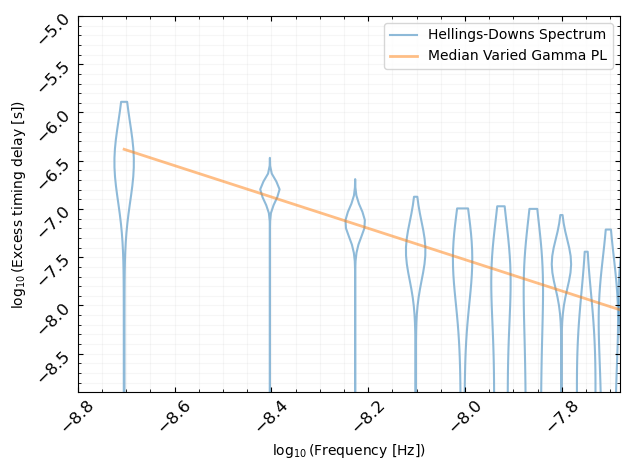

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111, rasterized=True)

# plot violins
v1 = ax.violinplot(hd_samples, positions=np.log10(freqs), 
                   widths=0.04, showextrema=False)
# label the HD spectrum
plt.plot([], [], color='C0', linestyle='solid', 
         label='Hellings-Downs Spectrum', alpha=0.5)

# Make the violins look good B)
for pc in v1['bodies']:
    pc.set_facecolor('None')
    pc.set_edgecolor('C0')
    pc.set_linestyle('solid')
    pc.set_alpha(0.5)
    pc.set_linewidth(1.5)

ax.set_ylim(-8.9, -5)
ax.set_xlim(-8.8, -7.68)
ax.grid(which='both',alpha=0.1)
# plot the median power law
ax.plot(np.log10(freqs), 0.5*np.log10(pl_med), color='C1', alpha=0.5, lw=2, label='Median Varied Gamma PL')

ax.minorticks_on()
ax.tick_params(which='both', direction='in', tick2On=True)

plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12, rotation=45)
plt.legend()

ax.set_ylabel(r'$\log_{10}$(Excess timing delay [s])')
ax.set_xlabel(r'$\log_{10}$(Frequency [Hz])')
plt.tight_layout()
plt.show()

## Spline ORF Fit

* To fit for HD correlations with Bayesian models, we use the HD correlated model. If we want to see this visually, we can use a spline fit to the ORF. First, we split the pulsars up into bins containing pulsar pairs with angles of separation on the sky. 

* There are seven spline knots at `[1e-3, 25.0, 49.3, 82.5, 121.8, 150.0, 180.0]` degrees each indicating that pulsar pairs in these bins will have a separation angle which is near each value.

* The vertical value at each of the $7$ values is allowed to vary and is sampled over with `PTMCMCSampler`

* To use this model, we choose the `orf=spline_orf` in `model_general`

In [31]:
pta = model_general(psrs, noisedict=wn_params, common_components=14, tm_svd=True,
                    orf='spline_orf', common_psd='powerlaw', tm_marg=True)

In [32]:
# gw spline parameters plus the powerlaw parameters
pta.params[134:]

[gw_orf_spline:Uniform(pmin=-0.9, pmax=0.9)[7],
 gw_spline_orf_gamma:Uniform(pmin=0, pmax=7),
 gw_spline_orf_log10_A:Uniform(pmin=-18, pmax=-11)]

In [33]:
%%capture
outdir = './chains/pe_splines'
sampler = ee_sampler.setup_sampler(pta, outdir=outdir, empirical_distr=emp_distr, resume=True)

In [34]:
# sampler for N iterations (uncomment the last line if you want to sample this yourself)
# PTMCMCSampler thins the chain by default, so we get 1/10th of the samples we ask for
N = int(5e6)
x0 = np.hstack([p.sample() for p in pta.params])
pars = pta.param_names
idx_orf_params = [list(pars).index(pp) for pp in pars if 'gw_orf_bin' in pp]

# start with an initial value given here for the spline parameters
x0[idx_orf_params] = [.01 for x in range(len(idx_orf_params))]

# sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

In [35]:
spline_core = core.Core(corepath=presampled + '/spline_orf_vg.core')

In [36]:
violins = [spline_core.get_param('gw_orf_spline_{}'.format(ii)) for ii in range(7)]

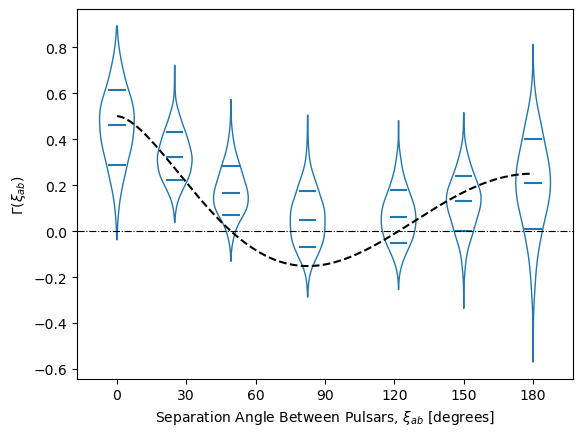

In [37]:
pos =  np.array([1e-3, 25.0, 49.3, 82.5,
                         121.8, 150.0, 180.0]) 
q = [[.158, 0.5, 0.84] for _ in range(len(pos))]

fig = plt.figure()
ax = fig.add_subplot(111, rasterized=True)
v1 = plt.violinplot(violins,positions=pos,
                   quantiles=q, bw_method=0.3,
                    widths=15.0, showextrema=False)

for pc in v1['bodies']:
    pc.set_facecolor('None')
    pc.set_edgecolor('C0')
    pc.set_linestyle('None')
    pc.set_alpha(1.0)

def hd_orf(xi):
    omc2 = (1 - np.cos(xi)) / 2
    return 1.5 * omc2 * np.log(omc2) - 0.25 * omc2 + 0.5

ax.plot(np.linspace(1e-3, np.pi,1000)*180.0/np.pi, 
        hd_orf(np.linspace(1e-3,np.pi,1000)), 
        lw = 1.5, color='k', ls = '--')
ax.axhline(0, color='k', ls='-.', lw=0.8)


plt.xticks(labels = ['0', '30', '60', '90', '120', '150', '180'], 
           ticks = np.array([0, 30, 60, 90, 120, 150, 180]))
plt.xlabel(r'Separation Angle Between Pulsars, $\xi_{ab}$ [degrees]',fontsize=10)
plt.ylabel(r'$\Gamma(\xi_{ab})$') 

plt.show()

* The HD curve plotted here as a dashed, black line fits reasonably well to the spline orf

* We use $7$ bins here, but we could have used any number of bins. We should find that the results are similar and that there is a consistent fit to the curve for each bin used.

## Conclusion

* This concludes the parameter estimation tutorial

* This covers $3/4$ of the plots in Figure 1 of the NANOGrav 15-year GWB paper